# Set the environment

In [1]:
# set the envoiroment
import cobra
from cobra import Model, Reaction, Metabolite
from cobra.flux_analysis import flux_variability_analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob 
import escher
from escher import Builder
from utils import show_map
from utils.check_precursor_problem import check_precursor_problem

## load the model

In [2]:
model = cobra.io.load_json_model("../models/updated_model.json")# Import the model.
model.solver = 'glpk'
model.reactions.T_flux_oxygen.bounds = (0,0) # block the import of oxygen
model.reactions.NGAM.bounds = (0,1000)
map_loc = "../data/new fermentation map.json"

## make the bounds of the small model

In [3]:
model1= model.copy()
## add the reaction for the maintainance of NADPH
reaction = Reaction('NADPH_recycle')
reaction.name = 'NADPH_recycle'
reaction.lower_bound = -100.  # This is the default
reaction.upper_bound = 1000.  # This is the default
model1.add_reactions([reaction])
reaction.add_metabolites({'NADPH': -1.0,
                         'NADP+': 1.0,
                         "H+":1.0})
reaction.reaction
## add the reaction for the maintainance of NADH
reaction = Reaction('NADH_recycle')
reaction.name = 'NADH_recycle'
reaction.lower_bound = -100.  # This is the default
reaction.upper_bound = 1000.  # This is the default
model1.add_reactions([reaction])
reaction.add_metabolites({'NADH': -1.0,
                         'NAD+': 1.0,
                         "H+":1.0})
reaction.reaction

total_reactions_id = [r.id for r in model1.reactions]
small_pathway_reactions = ["carb_glucneo_1.2.1.13_GAPDHSYNEC__RXN_NAD","carb_glucneo_1.2.1.13_GAPDHSYNEC__RXN_NADP","carb_enter_glucneo_2.7.2.3_PHOSGLYPHOS__RXN",
        "carb_enter_glucneo_1.2.1.9_1.2.1.9__RXN",'T_flux_H+','T_trans_H+','T_flux_H2O','T_trans_H2O','T_flux_phosphate','T_trans_phosphate',
        'carb_enter_glucneo_5.4.2.1_3PGAREARR__RXN','carb_enter_glucneo_4.2.1.11_2PGADEHYDRAT__RXN',
        'carb_enter_2.7.1.40_PEPDEPHOS__RXN','T_flux_D__glyceraldehyde__3__phosphate','NADPH_recycle','NADH_recycle']

for r in total_reactions_id:
    if r not in small_pathway_reactions:
        model1.reactions.get_by_id(r).upper_bound = 0
        model1.reactions.get_by_id(r).lower_bound = 0
    else:
        model1.reactions.get_by_id(r).bounds = (-10, 10)
model1.reactions.get_by_id('carb_enter_2.7.1.40_PEPDEPHOS__RXN').bounds = (0,1)
model1.reactions.get_by_id("carb_enter_glucneo_1.2.1.9_1.2.1.9__RXN").bounds = (0,1)


# With variation of n

## when 0<=n <=2

In [4]:
def different_n (n):     
    M = model1.copy()
    M.reactions.get_by_id('T_trans_phosphate').bounds = (-10,10)
    reaction = Reaction('from_pyruvate_to_GAP')
    reaction.name = 'from_pyruvate_to_GAP'
    reaction.lower_bound = -0.  # This is the default
    reaction.upper_bound = 10.  # This is the default
    M.add_reactions([reaction])
    reaction.add_metabolites({"pyruvate": -1.0,
                             "NAD+": -1.0,
                             "ATP": -n,
                             "D__glyceraldehyde__3__phosphate": 1.0,
                             "NADH": 1.0,
                              "H+": 1.0,
                             "ADP": n})

    M.objective = M.reactions.get_by_id('from_pyruvate_to_GAP')
    sol = M.optimize()
#     l = sol.fluxes[abs(sol.fluxes)>1e-6].index
#     for rxn in l:
#         print (rxn,M.reactions.get_by_id(rxn).reaction,sol.fluxes.loc[rxn])

#     print ("GAPN flux is " + str(sol.fluxes.loc['carb_enter_glucneo_1.2.1.9_1.2.1.9__RXN']),", GAPDH flux is " + str(-sol.fluxes.loc['carb_enter_glucneo_2.7.2.3_PHOSGLYPHOS__RXN']))
    return (str(sol.fluxes.loc['carb_enter_glucneo_1.2.1.9_1.2.1.9__RXN']),str(-sol.fluxes.loc['carb_enter_glucneo_2.7.2.3_PHOSGLYPHOS__RXN'])) 

In [5]:
df_Variation_n = pd.DataFrame(columns=['n', 'VGAPN', 'VGAPDH'])
df_Variation_n["n"]=np.arange(0, 2.1, step=0.2)
df_Variation_n = df_Variation_n.set_index(["n"])
for n in df_Variation_n.index:
    df_Variation_n["VGAPN"].loc[n] = float(different_n(n)[0])
    df_Variation_n["VGAPDH"].loc[n] = float(different_n(n)[1])
df_Variation_n=df_Variation_n.reset_index()
df_Variation_n

,n,VGAPN,VGAPDH
0,0.0,1,-0.5
1,0.2,1,-0.444444
2,0.4,1,-0.375
3,0.6,1,-0.285714
4,0.8,1,-0.166667
5,1.0,1,-0
6,1.2,0.8,0.2
7,1.4,0.6,0.4
8,1.6,0.4,0.6
9,1.8,0.2,0.8


## when n >2, for example n=3,  no solution

In [6]:
M = model1.copy()
M.reactions.get_by_id('T_trans_phosphate').bounds = (-10,10)


reaction = Reaction('from_pyruvate_to_GAP')
reaction.name = 'from_pyruvate_to_GAP'
reaction.lower_bound = -0.  # This is the default
reaction.upper_bound = 10.  # This is the default
M.add_reactions([reaction])
reaction.add_metabolites({"pyruvate": -1.0,
                         "NAD+": -1.0,
                         "ATP": -3,
                         "D__glyceraldehyde__3__phosphate": 1.0,
                         "NADH": 1.0,
                          "H+": 1.0,
                         "ADP": 3})

M.objective = M.reactions.get_by_id('from_pyruvate_to_GAP')
sol = M.optimize()
l = sol.fluxes[abs(sol.fluxes)>1e-6].index
for rxn in l:
    print (rxn,sol.fluxes.loc[rxn])
print ("GAPN flux is " + str(sol.fluxes.loc['carb_enter_glucneo_1.2.1.9_1.2.1.9__RXN']),", GAPDH flux is " + str(-sol.fluxes.loc['carb_enter_glucneo_2.7.2.3_PHOSGLYPHOS__RXN']))
# b = show_map(sol,map_loc)
# b 

GAPN flux is 0.0 , GAPDH flux is -0.0


# when adding ATPase reaction

In [7]:
M= model.copy()

reaction = Reaction('T_flux_pyruvate')
reaction.name = 'T_flux_pyruvate'
reaction.lower_bound = 0.  # This is the default
reaction.upper_bound = 1000.  # This is the default
M.add_reactions([reaction])
reaction.add_metabolites({'pyruvate': -1.0})
reaction.reaction

reaction = Reaction('T_flux_D__glyceraldehyde__3__phosphate')
reaction.name = 'T_flux_D__glyceraldehyde__3__phosphate'
reaction.lower_bound = -1  # This is the default
reaction.upper_bound = 0  # This is the default
M.add_reactions([reaction])
reaction.add_metabolites({
                         "D__glyceraldehyde__3__phosphate": -1.0})
reaction.reaction
## add the reaction for the maintainance of NADPH
reaction = Reaction('NADPH_recycle')
reaction.name = 'NADPH_recycle'
reaction.lower_bound = -100.  # This is the default
reaction.upper_bound = 1000.  # This is the default
M.add_reactions([reaction])
reaction.add_metabolites({'NADPH': -1.0,
                         'NADP+': 1.0,
                         "H+":1.0})
reaction.reaction
## add the reaction for the maintainance of NADH
reaction = Reaction('NADH_recycle')
reaction.name = 'NADH_recycle'
reaction.lower_bound = -100.  # This is the default
reaction.upper_bound = 1000.  # This is the default
M.add_reactions([reaction])
reaction.add_metabolites({'NADH': -1.0,
                         'NAD+': 1.0,
                         "H+":1.0})
reaction.reaction
total_reactions_id = [r.id for r in M.reactions]
small_pathway_reactions = ["carb_glucneo_1.2.1.13_GAPDHSYNEC__RXN_NAD","carb_glucneo_1.2.1.13_GAPDHSYNEC__RXN_NADP","carb_enter_glucneo_2.7.2.3_PHOSGLYPHOS__RXN",
        "carb_enter_glucneo_1.2.1.9_1.2.1.9__RXN",'T_flux_H+','T_trans_H+','T_flux_H2O','T_trans_H2O','T_flux_phosphate','T_trans_phosphate',
        'carb_enter_glucneo_5.4.2.1_3PGAREARR__RXN','carb_enter_glucneo_4.2.1.11_2PGADEHYDRAT__RXN',
        'carb_enter_2.7.1.40_PEPDEPHOS__RXN','T_flux_pyruvate','T_flux_D__glyceraldehyde__3__phosphate','NADPH_recycle','NADH_recycle']

for r in total_reactions_id:
    if r not in small_pathway_reactions:
        M.reactions.get_by_id(r).upper_bound = 0
        M.reactions.get_by_id(r).lower_bound = 0
    else:
        M.reactions.get_by_id(r).bounds = (-10, 10)
M.reactions.get_by_id("carb_enter_glucneo_1.2.1.9_1.2.1.9__RXN").bounds = (0,1)

In [8]:
def different_ATPase_bound (a,b):
    M.reactions.get_by_id('NGAM').bounds =(a,a)
    M.reactions.get_by_id('T_flux_D__glyceraldehyde__3__phosphate').bounds =(-b,0)
    M.objective = M.reactions.get_by_id('T_flux_pyruvate')
    sol = M.optimize()
    l = sol.fluxes[abs(sol.fluxes)>1e-6].index
#     for rxn in l:
#         print (rxn,M.reactions.get_by_id(rxn).reaction,sol.fluxes.loc[rxn],M.reactions.get_by_id(rxn).bounds)
    return(sol.fluxes.loc['carb_enter_glucneo_1.2.1.9_1.2.1.9__RXN'],-sol.fluxes.loc['carb_enter_glucneo_2.7.2.3_PHOSGLYPHOS__RXN'],sol.fluxes.loc['carb_enter_2.7.1.40_PEPDEPHOS__RXN'])

## T_flux_D__glyceraldehyde__3__phosphate bound was set to (-1,1)

In [9]:
df_Variation_ATPase = pd.DataFrame(columns=['ATPase', 'VGAPN', 'VGAPDH',"n"])
df_Variation_ATPase["ATPase"]= np.arange(0, 2.1, step=0.25)
df_Variation_ATPase = df_Variation_ATPase.set_index(["ATPase"])
for ATPase in df_Variation_ATPase.index:
    df_Variation_ATPase["VGAPN"].loc[ATPase] = different_ATPase_bound(ATPase,1)[0]
    df_Variation_ATPase["VGAPDH"].loc[ATPase] = different_ATPase_bound(ATPase,1)[1]
    df_Variation_ATPase["n"].loc[ATPase] = (df_Variation_ATPase["VGAPN"].loc[ATPase]+2*df_Variation_ATPase["VGAPDH"].loc[ATPase])/different_ATPase_bound(ATPase,1)[2]

In [10]:
df_Variation_ATPase

,VGAPN,VGAPDH,n
ATPase,,,
0.00,1,-0.5,0
0.25,1,-0.375,0.4
0.50,1,-0.25,0.666667
0.75,1,-0.125,0.857143
1.00,1,-0,1
1.25,0.75,0.25,1.25
1.50,0.5,0.5,1.5
1.75,0.25,0.75,1.75
2.00,0,1,2


## T_flux_D__glyceraldehyde__3__phosphate bound was set to (-1.5,1.5)

In [11]:
df_Variation_ATPase_with_high_GAP = pd.DataFrame(columns=['ATPase', 'VGAPN', 'VGAPDH',"n"])
df_Variation_ATPase_with_high_GAP["ATPase"]= np.arange(0, 3.1, step=0.25)
df_Variation_ATPase_with_high_GAP = df_Variation_ATPase_with_high_GAP.set_index(["ATPase"])
for ATPase in df_Variation_ATPase_with_high_GAP.index:
    df_Variation_ATPase_with_high_GAP["VGAPN"].loc[ATPase] = different_ATPase_bound(ATPase,1.5)[0]
    df_Variation_ATPase_with_high_GAP["VGAPDH"].loc[ATPase] = different_ATPase_bound(ATPase,1.5)[1]
    df_Variation_ATPase_with_high_GAP["n"].loc[ATPase] = (df_Variation_ATPase_with_high_GAP["VGAPN"].loc[ATPase]+2*df_Variation_ATPase_with_high_GAP["VGAPDH"].loc[ATPase])/different_ATPase_bound(ATPase,1.5)[2]

In [12]:
df_Variation_ATPase_with_high_GAP

,VGAPN,VGAPDH,n
ATPase,,,
0.00,1,-0.5,-1.33227e-15
0.25,1,-0.375,0.4
0.50,1,-0.25,0.666667
0.75,1,-0.125,0.857143
1.00,1,-6.01255e-16,1
1.25,1,0.125,1.11111
1.50,1,0.25,1.2
1.75,1,0.375,1.27273
2.00,1,0.5,1.33333


# Figure 1

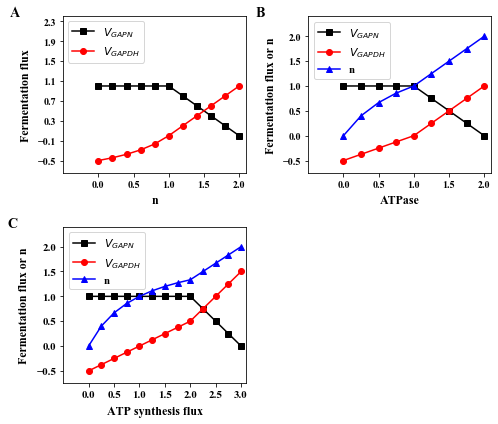

In [13]:
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Times New Roman"
fig = plt.figure(figsize = (7,6))

ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=1)
ax2 = plt.subplot2grid((2, 2), (0, 1), colspan=1)
ax3 = plt.subplot2grid((2, 2), (1, 0), colspan=1)
legend_properties = {'weight':'bold'}

ax1.plot(df_Variation_n["n"],df_Variation_n["VGAPN"],"s-",color='black', label = "$V_{GAPN}$")
ax1.plot(df_Variation_n["n"],df_Variation_n["VGAPDH"],"o-",color='red',label = "$V_{GAPDH}$")

ax1.legend(prop={"size":11,"weight":"bold"}, loc='upper left', borderaxespad=0.4)
ax1.text(-1.25, 2.4, 'A',  fontsize = 14, color ="black")
# ax1.set_yticklabels(["-1.0","-0.5","0","0.5","1.0","1.5","2.0"],fontsize = 10,fontweight = "bold")
ax1.set_yticks(np.arange(-0.5, 2.4, step=0.4))
ax1.set_xticks(np.arange(-0, 2.4, step=0.5))
ax1.set_ylim(-0.75, 2.4)
ax1.set_xlim (-0.5,2.1)
ax1.set_xlabel("n", fontsize = 12, fontweight = "bold",labelpad=6)
ax1.set_ylabel("Fermentation flux", fontsize = 12, fontweight = "bold",labelpad=6)

ax2.plot(df_Variation_ATPase.index,df_Variation_ATPase["VGAPN"],"s-",color='black',label = "$V_{GAPN}$")
ax2.plot(df_Variation_ATPase.index,df_Variation_ATPase["VGAPDH"],"o-",color='red',label = "$V_{GAPDH}$")
ax2.plot(df_Variation_ATPase.index,df_Variation_ATPase["n"],"^-",color='blue',label = "n")
# ax.plot(figure_S6["X"],figure_S6["-Jp/Jc total"],color='green',label = "-Jp/Jc total")
# ax2.plot(figure_S6["X"],figure_S6["-Jp/Jc for Optimal Z = q/2X"],color='purple', label = "n for optimal \n Z = q/2X")

ax2.legend(prop={"size":11,"weight":"bold"}, loc='upper left', borderaxespad=0.5)
ax2.text(-1.25, 2.4, 'B',  fontsize = 14, color ="black")
ax2.set_yticks(np.arange(-0.5, 2.4, step=0.5))
ax2.set_xticks(np.arange(-0, 2.4, step=0.5))
ax2.set_ylim(-0.75, 2.4)
ax2.set_xlim (-0.5,2.1)
ax2.set_xlabel("ATPase", fontsize = 12, fontweight = "bold",labelpad=6)
ax2.set_ylabel("Fermentation flux or n", fontsize = 12, fontweight = "bold",labelpad=6)


ax3.plot(df_Variation_ATPase_with_high_GAP.index,df_Variation_ATPase_with_high_GAP["VGAPN"],"s-",color='black',label = "$V_{GAPN}$")
ax3.plot(df_Variation_ATPase_with_high_GAP.index,df_Variation_ATPase_with_high_GAP["VGAPDH"],"o-",color='red',label = "$V_{GAPDH}$")
ax3.plot(df_Variation_ATPase_with_high_GAP.index,df_Variation_ATPase_with_high_GAP["n"],"^-",color='blue',label = "n")

ax3.legend(prop={"size":11,"weight":"bold"}, loc='upper left', borderaxespad=0.5)
# ax3.text(-0.37, 3.5, 'C',  fontsize = 14, color ="black")
ax3.text(-1.6, 2.4, 'C',  fontsize = 14, color ="black")
ax3.set_yticks(np.arange(-0.5, 2.4, step=0.5))
ax3.set_xticks(np.arange(-0, 3.1, step=0.5))
ax3.set_ylim([-0.75,2.4])
ax3.set_xlim ([-0.5,3.1])
ax3.set_xlabel("ATP synthesis flux", fontsize = 12, fontweight = "bold",labelpad=6)
ax3.set_ylabel("Fermentation flux or n", fontsize = 12, fontweight = "bold",labelpad=6)

plt.yticks(fontsize = 11,fontweight = "bold")
plt.xticks(fontsize = 11,fontweight = "bold")
# matplotlib.rc('ytick', labelsize=12) 
plt.tight_layout()

plt.savefig('../figures/Figure 1.png', dpi=300)
plt.show()

In [14]:
def different_ATPase_bound (a,b):
    M.reactions.get_by_id('NGAM').bounds =(a,a)
    M.reactions.get_by_id('T_flux_D__glyceraldehyde__3__phosphate').bounds =(-b,0)
    M.objective = M.reactions.get_by_id('T_flux_pyruvate')
    sol = M.optimize()
    l = sol.fluxes[abs(sol.fluxes)>1e-6].index
    for rxn in l:
        print (rxn,M.reactions.get_by_id(rxn).reaction,sol.fluxes.loc[rxn],M.reactions.get_by_id(rxn).bounds)
    print ("GAPN flux is " + str(sol.fluxes.loc['carb_enter_glucneo_1.2.1.9_1.2.1.9__RXN']),", GAPDH flux is " + str(-sol.fluxes.loc['carb_enter_glucneo_2.7.2.3_PHOSGLYPHOS__RXN']))
    print (", ATPase flux is " + str(sol.fluxes.loc['NGAM']))
    b = show_map(sol,map_loc)
    return(b)